In [1]:
!pip install neo4j

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.3/312.3 kB 3.3 MB/s eta 0:00:00


In [13]:
from neo4j import GraphDatabase
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from networkx.algorithms import community

In [ ]:
# Neo4j Connection
uri = "bolt://35.174.168.97:7687"
auth = ("neo4j", "tactic-supplies-retrievals")
driver = GraphDatabase.driver(uri, auth=auth)

def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        return pd.DataFrame([dict(record) for record in result])

In [ ]:
degree_query = """
MATCH (n)
OPTIONAL MATCH (n)-[r]-()
RETURN n.name as name, labels(n)[0] as type, count(r) as degree
ORDER BY degree DESC
LIMIT 10
"""
degree_df = run_query(degree_query)
print("Top 10 Nodes by Degree Centrality:")
print(degree_df)

Top 10 Nodes by Degree Centrality:
                        name            type  degree
0                       None        Resource     160
1                       None    TrainingRoom      30
2       Digital Learning Hub         Library      22
3          Innovation Portal         Library      22
4  Technical Resource Center         Library      21
5          Agile Methodology  TrainingCourse      20
6    Effective Communication  TrainingCourse      20
7     Emotional Intelligence  TrainingCourse      18
8  Data Science Fundamentals  TrainingCourse      18
9         Leadership Library         Library      18


In [ ]:
print("Checking GDS installation...")
gds_check = run_query("CALL gds.list() YIELD name RETURN name")
print("Installed GDS procedures:", gds_check['name'].to_list())

#Clean up any existing graph projection
run_query("CALL gds.graph.drop('trainingNetwork', false) YIELD graphName")

Checking GDS installation...
Installed GDS procedures: ['gds.allShortestPaths.delta.mutate', 'gds.allShortestPaths.delta.mutate.estimate', 'gds.allShortestPaths.delta.stats', 'gds.allShortestPaths.delta.stats.estimate', 'gds.allShortestPaths.delta.stream', 'gds.allShortestPaths.delta.stream.estimate', 'gds.allShortestPaths.delta.write', 'gds.allShortestPaths.delta.write.estimate', 'gds.allShortestPaths.dijkstra.mutate', 'gds.allShortestPaths.dijkstra.mutate.estimate', 'gds.allShortestPaths.dijkstra.stream', 'gds.allShortestPaths.dijkstra.stream.estimate', 'gds.allShortestPaths.dijkstra.write', 'gds.allShortestPaths.dijkstra.write.estimate', 'gds.allShortestPaths.stream', 'gds.alpha.ml.splitRelationships.mutate', 'gds.alpha.ml.splitRelationships.mutate.estimate', 'gds.alpha.pipeline.linkPrediction.addMLP', 'gds.alpha.pipeline.linkPrediction.configureAutoTuning', 'gds.alpha.pipeline.nodeClassification.addMLP', 'gds.alpha.pipeline.nodeClassification.configureAutoTuning', 'gds.alpha.pipeli

""


In [ ]:
degree_query = """
MATCH (n)
WHERE labels(n)[0] IN ['TrainingCourse', 'Trainer', 'Resource']
OPTIONAL MATCH (n)-[r]-()
WITH n, count(r) AS degree
RETURN n.name AS name, labels(n)[0] AS type, degree
ORDER BY degree DESC
LIMIT 10
"""
degree_df = run_query(degree_query)
print("\nTop 10 Nodes by Degree Centrality:")
print(degree_df.to_markdown(index=False))


Top 10 Nodes by Degree Centrality:
| name                      | type           |   degree |
|:--------------------------|:---------------|---------:|
| Effective Communication   | TrainingCourse |       18 |
| Agile Methodology         | TrainingCourse |       15 |
| Financial Literacy        | TrainingCourse |       14 |
| Digital Marketing         | TrainingCourse |       14 |
| Emotional Intelligence    | TrainingCourse |       14 |
| Data Science Fundamentals | TrainingCourse |       13 |
| Leadership Development    | TrainingCourse |       11 |
| Design Thinking           | TrainingCourse |       11 |
| Time Management           | TrainingCourse |       10 |
| Diversity & Inclusion     | TrainingCourse |       10 |


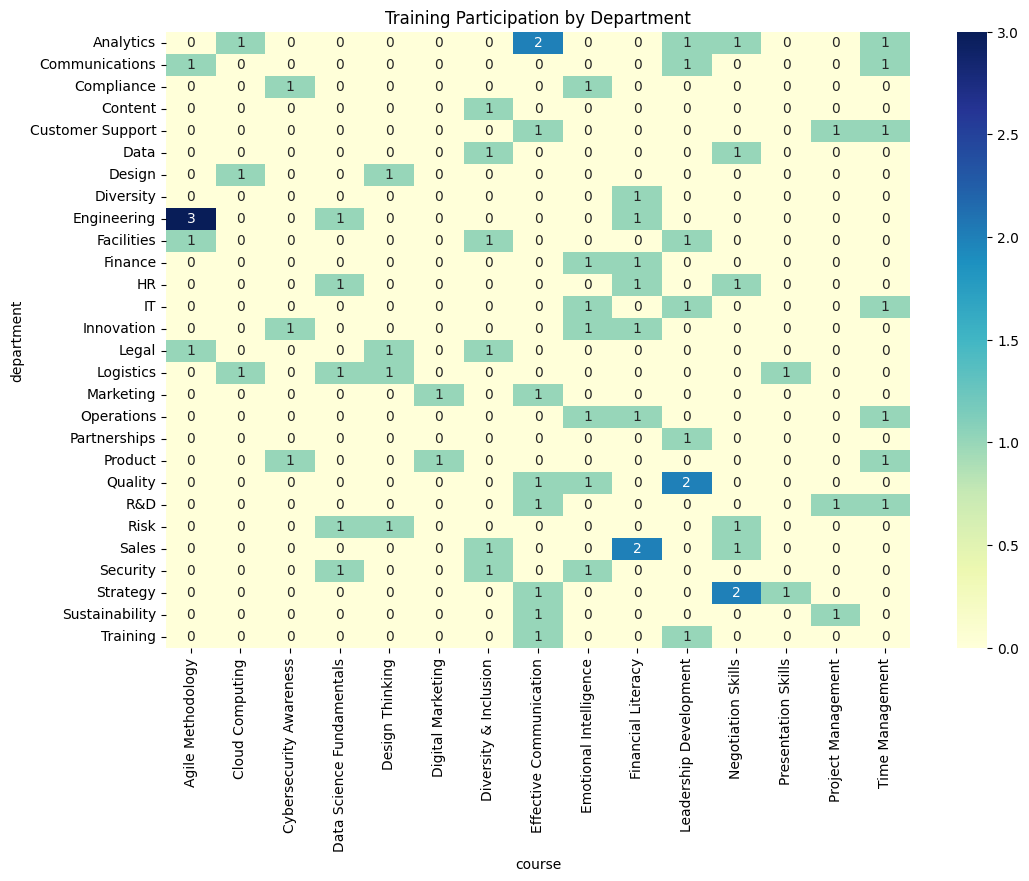

In [ ]:
participation_query = """
MATCH (e:Employee)-[:ENROLLED_IN]->(c:TrainingCourse)
RETURN e.department as department, c.name as course, count(*) as count
"""
participation_df = run_query(participation_query)
heatmap_data = participation_df.pivot(index='department', columns='course', values='count')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data.fillna(0), cmap="YlGnBu", annot=True, fmt=".0f")
plt.title("Training Participation by Department")
plt.show()

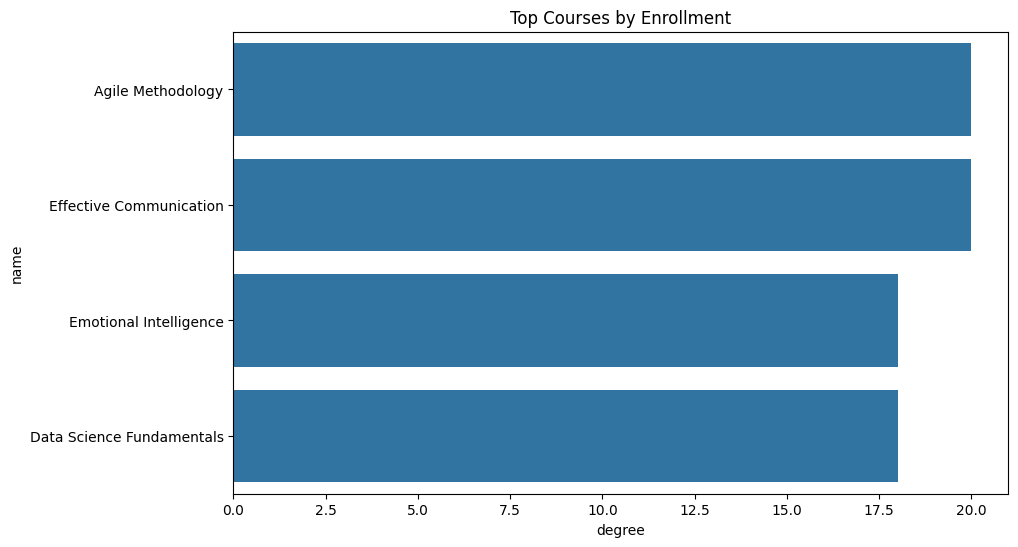

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='degree', y='name', data=degree_df[degree_df['type'] == 'TrainingCourse'])
plt.title("Top Courses by Enrollment")
plt.show()

In [9]:
def fetch_relationships():
    """
    Fetches relationships from the Neo4j database, filtering out
    relationships where either the source or target node has a missing 'name' property.
    This prevents the ValueError that occurs when trying to add edges with None values.
    """
    query = """
    MATCH (a)-[r]->(b)
    WHERE a.name IS NOT NULL AND b.name IS NOT NULL
    RETURN a.name AS source, b.name AS target, type(r) AS relation
    """
    with db.session() as session:
        results = session.run(query)
        return [(record["source"], record["target"], record["relation"]) for record in results]

# Load data into NetworkX
edges = fetch_relationships()
G = nx.DiGraph()
G.add_edges_from([(src, tgt) for src, tgt, _ in edges])

# Compute centrality measures
centrality = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G)
closeness = nx.closeness_centrality(G)

In [11]:
# Compute clustering coefficient (only for undirected graphs)
G_undirected = G.to_undirected()
clustering_coeff = nx.average_clustering(G_undirected)

In [14]:
# Community Detection
communities = community.greedy_modularity_communities(G_undirected)
community_mapping = {}
for i, comm in enumerate(communities):
    for node in comm:
        community_mapping[node] = i

In [15]:
# Apply PageRank Algorithm
pagerank = nx.pagerank(G, alpha=0.85)

# Apply HITS Algorithm
hits_hub, hits_auth = nx.hits(G)

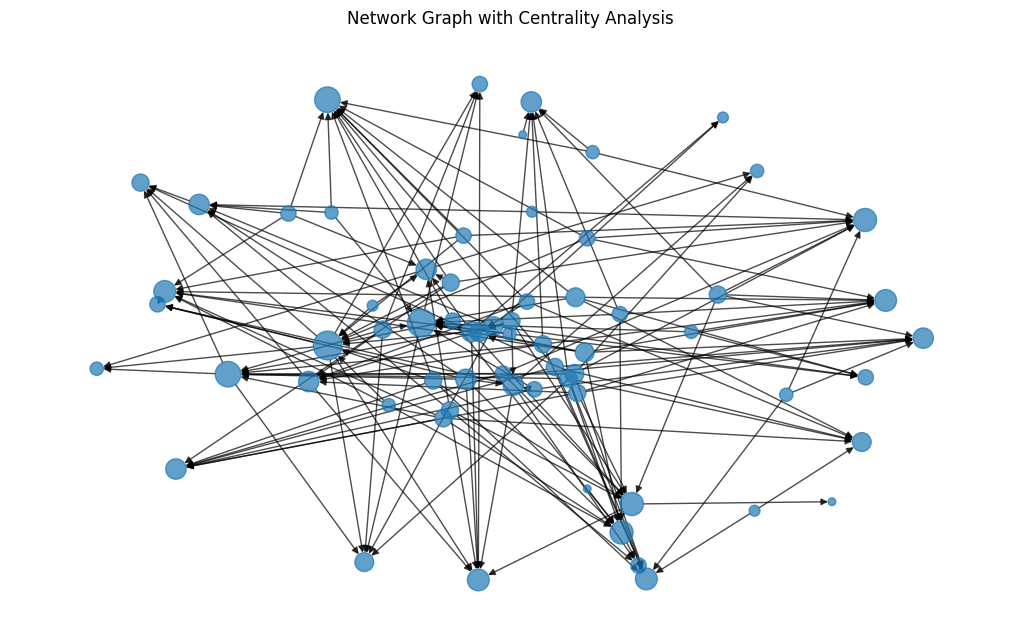

In [8]:
# Visualization
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=[v * 2000 for v in centrality.values()], alpha=0.7)
plt.title("Network Graph with Centrality Analysis")
plt.show()

In [27]:
# Print analysis results
print("Top 5 nodes by Degree Centrality:")
print(sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:5])

Top 5 nodes by Degree Centrality:
[('Emotional Intelligence', 0.2153846153846154), ('Effective Communication', 0.2), ('Innovation Portal', 0.16923076923076924), ('Agile Methodology', 0.16923076923076924), ('Leadership Development', 0.13846153846153847)]


In [26]:
print("Top 5 nodes by Betweenness Centrality:")
print(sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:5])

Top 5 nodes by Betweenness Centrality:
[('Emotional Intelligence', 0.00985576923076923), ('Agile Methodology', 0.0045673076923076926), ('Effective Communication', 0.003966346153846154), ('Data Science Fundamentals', 0.0024639423076923076), ('Presentation Skills', 0.002103365384615385)]


In [24]:
print("Top 5 nodes by Closeness Centrality:")
print(sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:5])

Top 5 nodes by Closeness Centrality:
[('Customer Experience', 0.22893772893772896), ('Sales & Marketing', 0.22888540031397173), ('Legal', 0.22608695652173913), ('Information Technology', 0.1937728937728938), ('Human Resources', 0.1739644970414201)]


In [23]:
print(f"Average Clustering Coefficient: {clustering_coeff}")

Average Clustering Coefficient: 0.03050602596057142


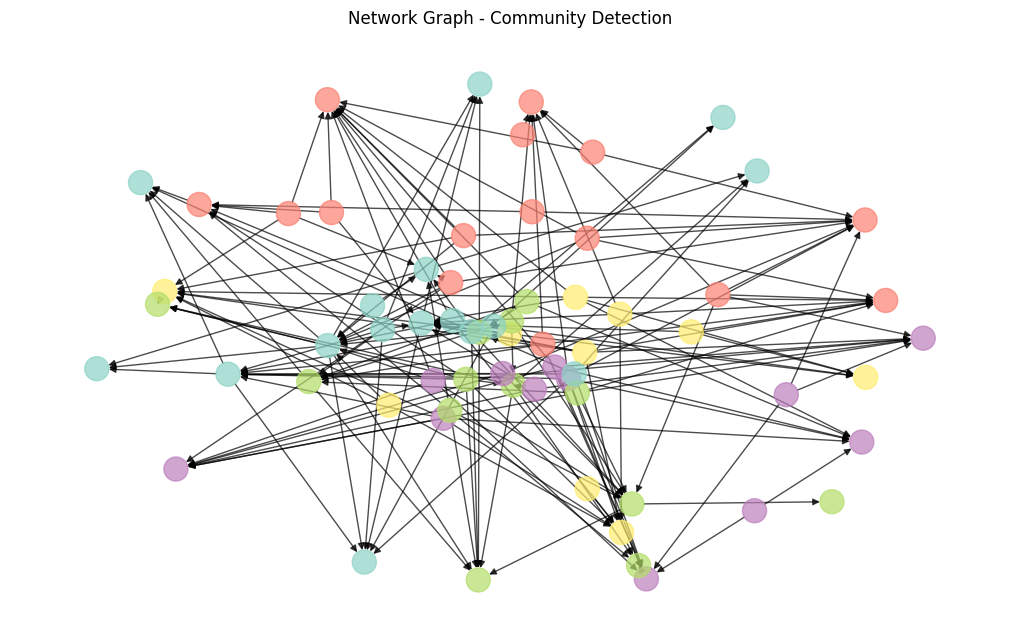

Detected Communities:
Community 1: ['Prof. Foster', 'Dr. Bennett', 'Emotional Intelligence', 'Operations', 'Thomas Miller', 'Effective Communication', 'Finance', 'Sales & Marketing', 'Legal', 'Nicole White', 'Information Technology', 'Agile Methodology', 'Coach Gray', 'Coach Diaz', 'Cybersecurity Awareness', 'Human Resources']
Community 2: ['Rachel Green', 'Jessica Brown', 'Digital Learning Hub', 'Hannah Carter', 'Digital Marketing', 'David Kim', 'Prof. Carter', 'Financial Literacy', 'James Wilson', 'Jennifer Lee', 'Emily Park', 'Leadership Library', 'Katherine Sanders', 'Amanda Johnson', 'Innovation Portal']
Community 3: ['Product Management', 'Data Science Fundamentals', 'Coach Anderson', 'Corporate Strategy', 'Presentation Skills', 'Customer Experience', 'Cloud Computing', 'Design Thinking', 'Research & Development', 'Samantha Evans', 'Dr. Edwards', 'Matthew Lewis', 'Kevin Davis']
Community 4: ['Andrew Allen', 'Joshua Wright', 'Diversity & Inclusion', 'Compliance Knowledge Base', 'C

In [30]:
plt.figure(figsize=(10, 6))
colors = [community_mapping.get(node, 0) for node in G.nodes()]
nx.draw(G, pos, node_color=colors, cmap=plt.cm.Set3, alpha=0.7)
plt.title("Network Graph - Community Detection")
plt.show()

print("Detected Communities:")
for i, comm in enumerate(communities):
    print(f"Community {i+1}: {list(comm)}")

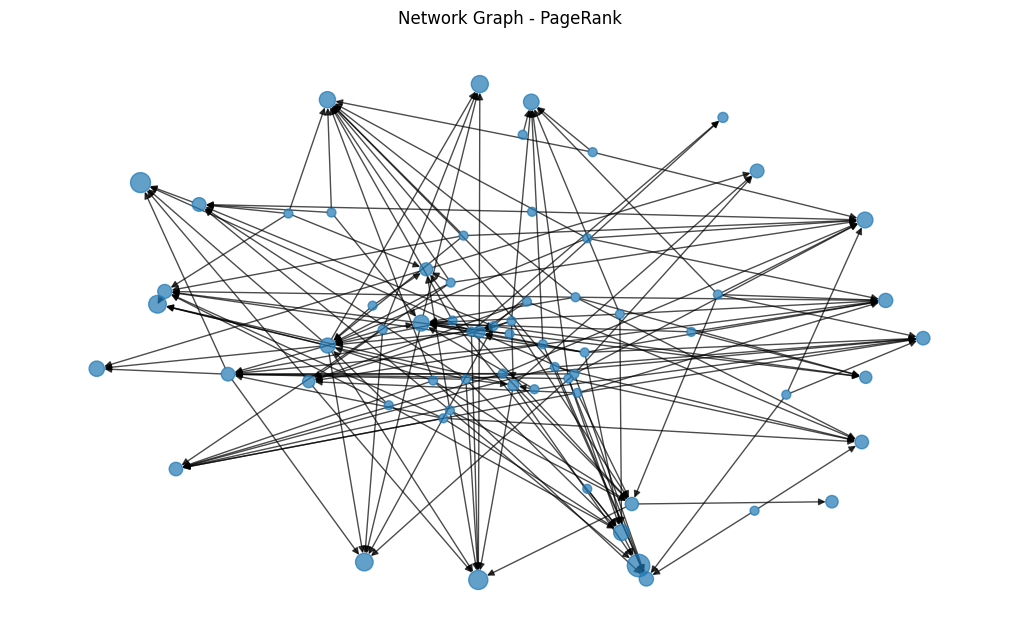

Top 5 nodes by PageRank:
[('Product Management', 0.052497508220639415), ('Sales & Marketing', 0.04127912661152808), ('Customer Experience', 0.037922695645820424), ('Research & Development', 0.03249919405094863), ('Legal', 0.03205638960528257)]


In [32]:
plt.figure(figsize=(10, 6))
nx.draw(G, pos, node_size=[v * 5000 for v in pagerank.values()], alpha=0.7)
plt.title("Network Graph - PageRank")
plt.show()

print("Top 5 nodes by PageRank:")
print(sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5])

In [36]:
print("Top 5 nodes by HITS Hub Scores:")
print(sorted(hits_hub.items(), key=lambda x: x[1], reverse=True)[:5])

Top 5 nodes by HITS Hub Scores:
[('Daniel Martin', 0.043882743772246914), ('Stephanie Young', 0.04165885923692734), ('Laura Hall', 0.036282493974733286), ('Hannah Carter', 0.035495869242525936), ('Christopher Adams', 0.03496684172455139)]


In [17]:
print("Top 5 nodes by HITS Authority Scores:")
print(sorted(hits_auth.items(), key=lambda x: x[1], reverse=True)[:5])

Top 5 nodes by HITS Authority Scores:
[('Innovation Portal', 0.07602554229937765), ('Effective Communication', 0.07334323862018774), ('Leadership Library', 0.058391696032651756), ('Financial Literacy', 0.053503218450575915), ('Agile Methodology', 0.05232271587191964)]
